In [1]:
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import pylab
from landlab.plot.imshow import imshow_grid
from landlab.plot.imshow import imshow_grid_at_node
from landlab.io import read_esri_ascii
from landlab.components.flow_accum import find_drainage_area_and_discharge
from landlab.components import FlowAccumulator, SinkFillerBarnes, DepressionFinderAndRouter
from landlab.components.landslides import LandslideProbability
import time
st = time.time()

In [2]:
(mg, Z) = read_esri_ascii('dem_30m.asc', name = 'topographic__elevation')

In [3]:
mg.set_nodata_nodes_to_closed(Z,-9999.)
outlet_id = mg.core_nodes[np.argmin(mg.at_node['topographic__elevation'][mg.core_nodes])]
mg.set_watershed_boundary_condition_outlet_id(outlet_id, Z)

Zmin = np.min(mg.at_node['topographic__elevation'][mg.core_nodes])
Zmax = np.max(mg.at_node['topographic__elevation'][mg.core_nodes])

print("Outlet ID=", outlet_id)                                        
print("Outlet elevation=",mg.at_node['topographic__elevation'][outlet_id])        
print("Min elevation of core nodes=", Zmin)
print("Max elevation of core nodes=", Zmax)

Outlet ID= 408536
Outlet elevation= 88.0
Min elevation of core nodes= 88.0
Max elevation of core nodes= 3235.0


C:\Users\kayli\anaconda3\envs\landlab_dev\lib\site-packages\landlab\plot\imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  cmap.set_bad(color=color_for_closed)
C:\Users\kayli\anaconda3\envs\landlab_dev\lib\site-packages\landlab\plot\imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


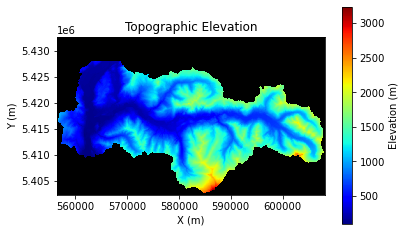

In [4]:
imshow_grid(mg,'topographic__elevation', plot_name = 'Topographic Elevation', 
            var_name = 'Elevation', var_units = 'm', grid_units = ('m','m'), 
            cmap = 'jet', limits = (88., 3235.))

In [5]:
fa = FlowAccumulator(mg,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorD8',
                    runoff_rate = None,
                    depression_finder = 'DepressionFinderAndRouter')

(da, q) = fa.accumulate_flow()
print('max drainage area (km^2) =', np.max(mg.at_node['drainage_area'][mg.nodes])/1000000)

max drainage area (km^2) = 746.5617


In [6]:
sf = SinkFillerBarnes(mg, surface = 'topographic__elevation', method = 'D8', fill_flat = False, ignore_overfill = False)
sf.run_one_step()

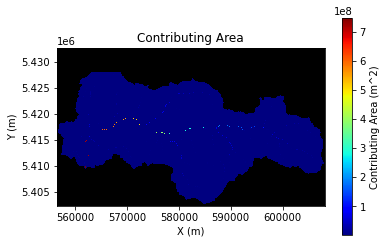

In [7]:
imshow_grid(mg,'drainage_area', plot_name = 'Contributing Area', 
            var_name = 'Contributing Area', var_units = 'm^2', grid_units = ('m','m'), 
            cmap = 'jet')

(5416000.0, 5419000.0)

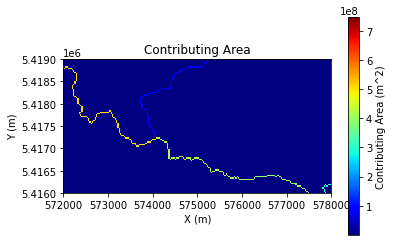

In [8]:
f, ax = plt.subplots()
imshow_grid(mg,'drainage_area', plot_name = 'Contributing Area', 
            var_name = 'Contributing Area', var_units = 'm^2', grid_units = ('m','m'), 
            cmap = 'jet')
ax.set_xlim([572000, 578000])
ax.set_ylim([5.416*10**6, 5.419*10**6])

C:\Users\kayli\AppData\Local\Temp/ipykernel_5752/2723502260.py:1: RuntimeWarning: divide by zero encountered in log10
  imshow_grid(mg, np.log10(da), plot_name = 'Catchment Area',


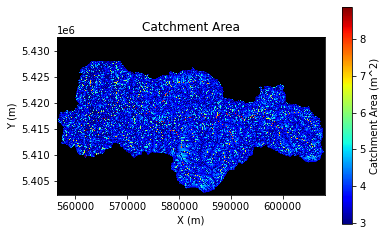

In [9]:
imshow_grid(mg, np.log10(da), plot_name = 'Catchment Area', 
            var_name = 'Catchment Area', var_units = 'm^2', grid_units = ('m','m'), 
            cmap = 'jet')

In [10]:
# f, ax = plt.subplots()
# imshow_grid(mg, np.log10(da), plot_name = 'Catchment Area', 
#             var_name = 'Catchment Area', var_units = 'm^2', grid_units = ('m','m'), 
#             cmap = 'jet')
# ax.set_xlim([572000, 578000])
# ax.set_ylim([5.416*10**6, 5.419*10**6])

Calculating Specific Catchment Area and Slope

In [11]:
cell_width = mg.dx
ca = mg.at_node['drainage_area']/cell_width
_=mg.add_field('node', 'topographic__specific_contributing_area', ca, clobber=True)
slope = mg.calc_slope_at_node(Z)
_= mg.add_field('node', 'topographic__slope', slope, clobber = True)

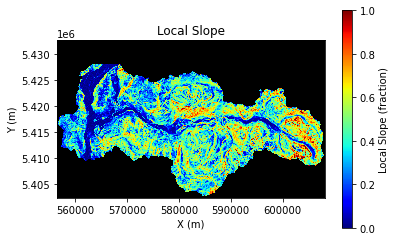

In [12]:
imshow_grid(mg,'topographic__slope', plot_name = 'Local Slope', 
            var_name = 'Local Slope', var_units = 'fraction', grid_units = ('m','m'), 
            cmap = 'jet', limits = (0, 1))

Landslide Probability Input Variables

In [13]:
sorted(LandslideProbability.input_var_names)

['soil__density',
 'soil__internal_friction_angle',
 'soil__maximum_total_cohesion',
 'soil__minimum_total_cohesion',
 'soil__mode_total_cohesion',
 'soil__saturated_hydraulic_conductivity',
 'soil__thickness',
 'soil__transmissivity',
 'topographic__slope',
 'topographic__specific_contributing_area']

Variable Units

In [14]:
print('soil mode total cohesion:', LandslideProbability.var_units('soil__mode_total_cohesion'))
print('saturated hydraulic conductivity:', LandslideProbability.var_units('soil__saturated_hydraulic_conductivity'))
print('soil transmissivity:', LandslideProbability.var_units('soil__transmissivity'))
print('soil internal friction angle:', LandslideProbability.var_units('soil__internal_friction_angle'))
print('soil thickness:', LandslideProbability.var_units('soil__thickness'))

soil mode total cohesion: Pa or kg/m-s2
saturated hydraulic conductivity: m/day
soil transmissivity: m2/day
soil internal friction angle: degrees
soil thickness: m


Loading cohesion files produced in nf_nooksack_cohesiondata.ipynb

In [15]:
C_min = np.loadtxt('C_min.csv')
Cmode = np.loadtxt('Cmode.csv')
C_max = np.loadtxt('C_max.csv')

In [16]:
_=mg.add_field('node', 'soil__minimum_total_cohesion', C_min, clobber=True)
_=mg.add_field('node', 'soil__mode_total_cohesion', Cmode, clobber=True)
_=mg.add_field('node', 'soil__maximum_total_cohesion', C_max, clobber=True)

Defining the other variables based on the values used in Ronda's paper, though hs and Ks values can be replaced by the data aquired from gSSURGO.  

In [17]:
Phi = 35  # degrees, using the average of the mode values in Ronda's paper
Ks =  7   # m d^-1, value in Ronda's paper
hs_min = 0.09  # m, minimum in Ronda's paper
hs_max = 2.01  # m, maximum in Ronda's paper
soil_density = 2000 # kg m^-3, used in Ronda's, is default in a different model cited in the paper

In [18]:
mg.add_field('node', 'soil__density', soil_density*np.ones(mg.number_of_nodes), clobber=True)
mg.add_field('node', 'soil__internal_friction_angle', Phi*np.ones(mg.number_of_nodes), clobber=True)
mg.add_field('node', 'soil__saturated_hydraulic_conductivity', Ks*np.ones(mg.number_of_nodes), clobber=True)

array([ 7.,  7.,  7., ...,  7.,  7.,  7.])

Soil Depth

In [19]:
hs=hs_max-((Z-Zmin)/(Zmax-Zmin))*(hs_max-hs_min)
_=mg.add_field('node', 'soil__thickness', hs*np.ones(mg.number_of_nodes), clobber=True)

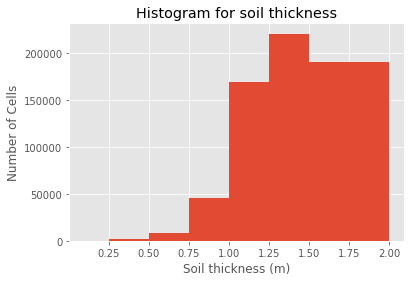

In [20]:
prob = mg.at_node['soil__thickness']
plt.style.use('ggplot')
plt.hist(prob, bins=[0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2])
plt.xlabel('Soil thickness (m)')
plt.ylabel ('Number of Cells')
plt.title('Histogram for soil thickness')
plt.ylim = 100000
plt.show()

C:\Users\kayli\anaconda3\envs\landlab_dev\lib\site-packages\landlab\plot\imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("copper_r").copy()
  cmap.set_bad(color=color_for_closed)
C:\Users\kayli\anaconda3\envs\landlab_dev\lib\site-packages\landlab\plot\imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


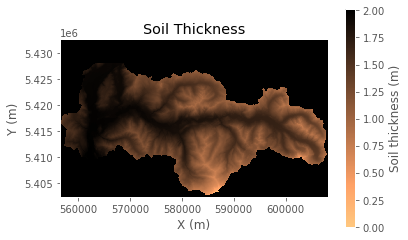

In [21]:
imshow_grid(mg,'soil__thickness', plot_name = 'Soil Thickness', 
            var_name = 'Soil thickness', var_units = 'm', grid_units = ('m','m'), 
            cmap = 'copper_r',limits = (0, 2.01))

Transmissivity

In [23]:
To=Ks*hs
_=mg.add_field('node', 'soil__transmissivity', To*np.ones(mg.number_of_nodes), clobber=True)

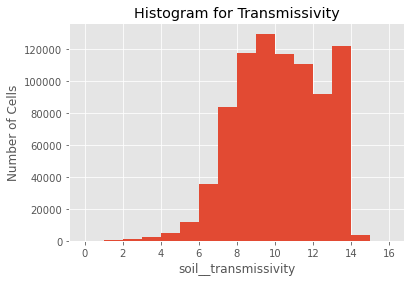

In [24]:
prob = mg.at_node['soil__transmissivity']
plt.style.use('ggplot')
plt.hist(prob, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
plt.xlabel('soil__transmissivity')
plt.ylabel ('Number of Cells')
plt.title('Histogram for Transmissivity')
plt.ylim = 100000
plt.show()

C:\Users\kayli\anaconda3\envs\landlab_dev\lib\site-packages\landlab\plot\imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Greens").copy()
  cmap.set_bad(color=color_for_closed)
C:\Users\kayli\anaconda3\envs\landlab_dev\lib\site-packages\landlab\plot\imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


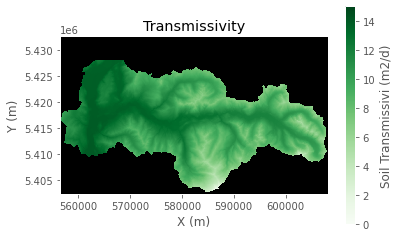

In [25]:
imshow_grid(mg,'soil__transmissivity', plot_name = 'Transmissivity', 
            var_name = 'Soil Transmissivi', var_units = 'm2/d', grid_units = ('m','m'), 
            cmap = 'Greens',limits = (0, 15))

Using groundwater recharge values from landslide probability tutorial, find groundwater recharge values?

In [26]:
groundwater__recharge_mean=15; 
groundwater__recharge_standard_deviation=1; 
groundwater__recharge_minimum = 1.3 # recharge in mm/d
groundwater__recharge_maximum = 4.3

For final modeling purposes in the paper it says: "700 to >1200 iterations found to be sufficient"

In [27]:
number_of_iterations = 500
LS_prob=LandslideProbability(mg,
                         number_of_iterations=number_of_iterations,
                         groundwater__recharge_distribution='lognormal',
                         groundwater__recharge_mean=groundwater__recharge_mean,
                         groundwater__recharge_standard_deviation=groundwater__recharge_standard_deviation)

In [28]:
LS_prob.calculate_landslide_probability()

C:\Users\kayli\anaconda3\envs\landlab_dev\lib\site-packages\landlab\components\landslides\landslide_probability.py:552: RuntimeWarning: divide by zero encountered in float_scalars
  self._a / np.sin(np.arctan(self._theta))
C:\Users\kayli\anaconda3\envs\landlab_dev\lib\site-packages\landlab\components\landslides\landslide_probability.py:567: RuntimeWarning: divide by zero encountered in true_divide
  self._FS = (self._C_dim / np.sin(np.arctan(self._theta))) + (
C:\Users\kayli\anaconda3\envs\landlab_dev\lib\site-packages\landlab\components\landslides\landslide_probability.py:568: RuntimeWarning: divide by zero encountered in true_divide
  np.cos(np.arctan(self._theta)) * (Y / np.sin(np.arctan(self._theta)))


Relative Wetness

C:\Users\kayli\anaconda3\envs\landlab_dev\lib\site-packages\landlab\plot\imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("YlGnBu").copy()
  cmap.set_bad(color=color_for_closed)


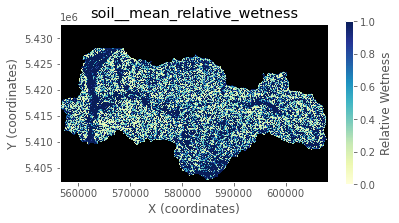

In [29]:
plt.figure('Mean Relative Wetness')
imshow_grid_at_node(mg, 'soil__mean_relative_wetness', cmap='YlGnBu',
                 grid_units=('coordinates', 'coordinates'),
                 shrink=0.75, var_name='Relative Wetness')

Probability Failure Mapping

C:\Users\kayli\anaconda3\envs\landlab_dev\lib\site-packages\landlab\plot\imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("OrRd").copy()
  cmap.set_bad(color=color_for_closed)


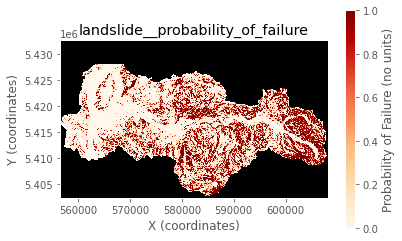

In [31]:
plt.figure('Probability of Failure')
imshow_grid_at_node(mg, 'landslide__probability_of_failure', cmap='OrRd',
                 grid_units=('coordinates', 'coordinates'), shrink=1,
                 var_name='Probability of Failure', var_units='no units')

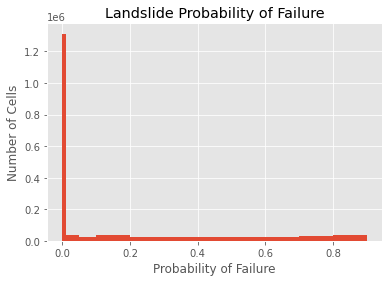

In [32]:
prob = mg.at_node['landslide__probability_of_failure']
plt.style.use('ggplot')
plt.hist(prob, bins=[0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
plt.xlabel('Probability of Failure')
plt.ylabel ('Number of Cells')
plt.title('Landslide Probability of Failure')
plt.show()